In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#scaler
from sklearn.preprocessing import StandardScaler
#model_selection
from sklearn.model_selection import GridSearchCV
#PCA
from sklearn.decomposition import PCA

In [160]:
data = pd.read_csv('heart.csv')
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [161]:
#I calculate Z scores for RestingBP, Cholesterol, MaxHR columns.

data['RestingBP_zscore'] = (data.RestingBP-data.RestingBP.mean())/data.RestingBP.std()
data['Cholesterol_zscore'] = (data.Cholesterol-data.Cholesterol.mean())/data.Cholesterol.std()
data['MaxHR_zscore'] = (data.MaxHR-data.MaxHR.mean())/data.MaxHR.std()
data['Oldpeak_zscore'] = (data.Oldpeak-data.Oldpeak.mean())/data.Oldpeak.std()

filtered_data = data[(3>data.RestingBP_zscore) & (-3<data.RestingBP_zscore) & (3>data['Cholesterol_zscore'])& (data['Cholesterol_zscore']>-3) & (data['MaxHR_zscore']<3) & (data['MaxHR_zscore']>-3) & (data['Oldpeak_zscore']<3) & (data['Oldpeak_zscore']>-3)]
# with this filter I removed about 20 outliers

In [162]:
final_data = filtered_data.drop(columns=['RestingBP_zscore', 'Cholesterol_zscore', 'MaxHR_zscore', 'Oldpeak_zscore'])

In [163]:
# now i want to convert columns with one hot encoding

data_with_dummies = pd.get_dummies(final_data, drop_first=True, dtype = int)
data_with_dummies
y = data_with_dummies.HeartDisease
X = data_with_dummies.drop(columns = ['HeartDisease'])
X.shape

(899, 15)

<Axes: >

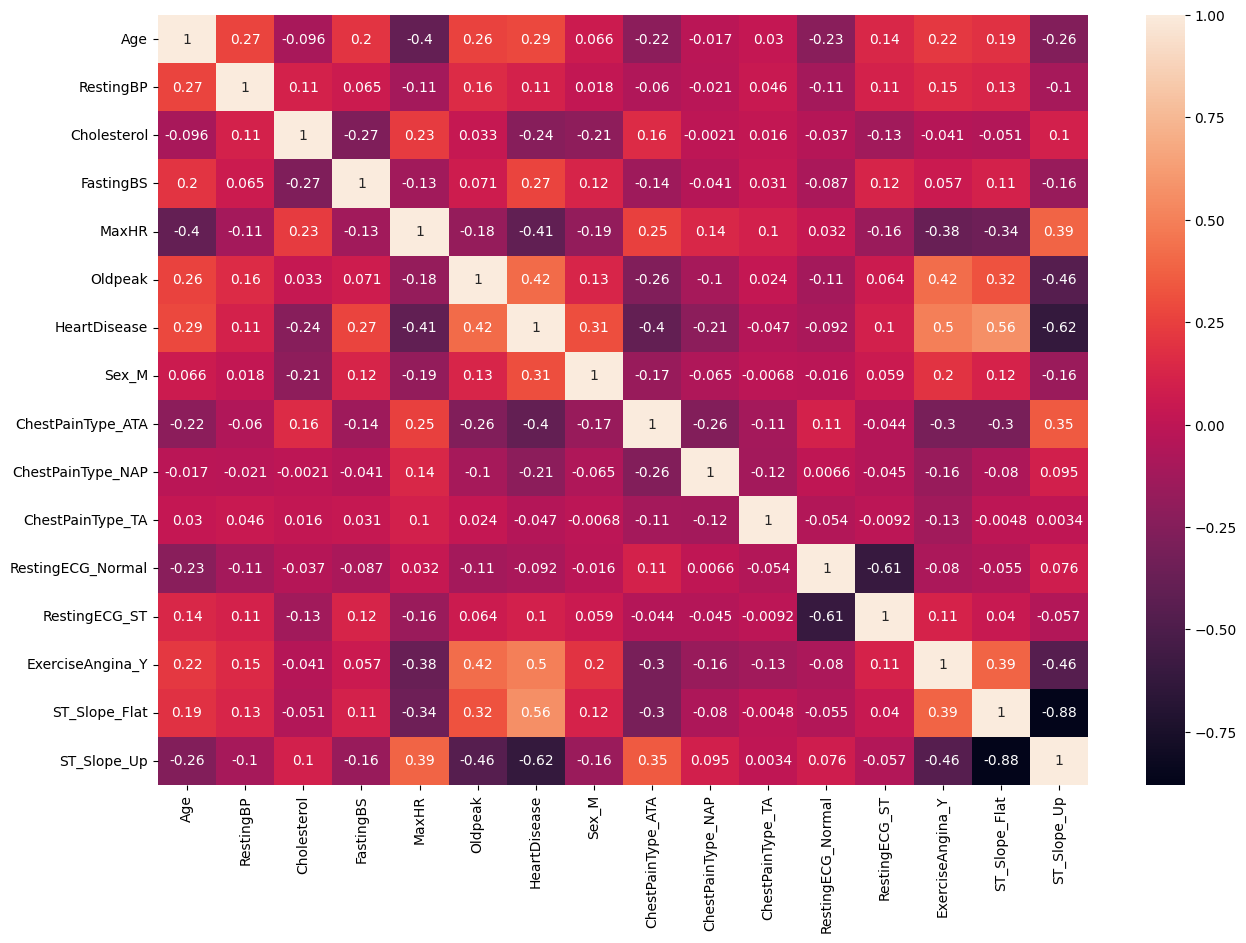

In [164]:
corr = data_with_dummies.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr , annot = True)

# None of the variables present a significative non-correlation with our target variable to be removed

In [165]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [166]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma = 'auto'),
        'params':{
            'C': [1,10,20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params':{
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [1,10,20],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        }
    },
    'gaussian_nb': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9,1e-7,1e-5]
        }
    },
    'k_neighbors': {
        'model':KNeighborsClassifier(),
        'params': {
            'n_neighbors': list(range(1,11)),
            'weights': ['uniform', 'distance']
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_depth': [5,15,30]
        }
    }
}

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [168]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [169]:
df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
df.sort_values('best_score', inplace =True, ascending = False)
df
#Got the best result for the SVM algorithm with parameters: C = 10 and kernel = 'linear'

,model,best_score,best_params
0,svm,0.873456,"{'C': 1, 'kernel': 'rbf'}"
4,k_neighbors,0.873446,"{'n_neighbors': 8, 'weights': 'distance'}"
2,logistic_regression,0.866502,"{'C': 1, 'solver': 'liblinear'}"
3,gaussian_nb,0.860927,{'var_smoothing': 1e-09}
5,decision_tree,0.856760,"{'criterion': 'log_loss', 'max_depth': 5, 'spl..."
1,random_forest,0.851204,{'n_estimators': 10}


In [170]:
model = SVC(C = 10, kernel = 'linear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8611111111111112

In [171]:
pca = PCA(0.97)
X_pca = pca.fit_transform(X)

In [172]:
pca.explained_variance_ratio_

array([0.92112603, 0.0506488 ])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

model = SVC(C = 10, kernel = 'linear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

# without PCA, we got 0.86 scoress
# doing PCA(0.95) got us 0.7 score
# doing PCA(0.75) got us 0.75 score
# doing PCA(n_components = 10) got us 0.8 score


0.75